In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate,BatchNormalization,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-06-21 10:44:36.062014: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-21 10:44:36.067014: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-21 10:44:36.067031: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

#### Loading the ISOT Full Dataset  -- After combined fake and real news  in the previous notebook   "ISOT_ML_Classifiers_TfiDF_Tokeniser"

In [65]:
isot_full_df = pd.read_csv("Updated//ISOT_Combined_FullData.csv")

In [66]:
df = isot_full_df[isot_full_df['fulltext'].notna()]

In [67]:
df.shape

(38270, 8)

In [5]:
df['fulltext'].isnull().sum()

0

In [6]:
## Shuffling the rows
df = df.sample(frac=1).reset_index(drop=True)

In [7]:
# Clean data using the built in cleaner in gensim
df['cleantext'] = df['fulltext'].apply(lambda x: gensim.utils.simple_preprocess(x))
#df.head(1)

In [8]:
X=df['cleantext']
y=df['class']

### Train and Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

In [10]:
# now since we will have to pad we need to find the maximum lenght of any document.

maxi=-1
for i,sent in enumerate(df['cleantext']):
    if(len(sent)>maxi):
        maxi=len(sent)
print(maxi)

7912


In [11]:
print("Maximum Length of the sequence : ",maxi)

Maximum Length of the sequence :  7912


#### Now we integer encode the words in the reviews using Keras tokenizer.

In [12]:
tokenzr = Tokenizer()

In [13]:
tokenzr.fit_on_texts(X_train)
vocab_size = len(tokenzr.word_index) + 1
encd_train = tokenzr.texts_to_sequences(X_train)

In [14]:
encd_test = tokenzr.texts_to_sequences(X_test)

##### Configuration Setting

In [15]:
print(len(tokenzr.word_index))

102681


In [16]:
maxi=2000  # max lenght of a review
vocab_size = len(tokenzr.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

In [17]:
# now padding to have a maximum length of 17351
pad_train= pad_sequences(encd_train, maxlen=maxi, padding='post')
pad_train.shape   

(30616, 2000)

In [18]:
# now padding to have a maximum length of 1565
pad_test= pad_sequences(encd_test, maxlen=maxi, padding='post')
pad_test.shape

(7654, 2000)

In [32]:
import matplotlib.pyplot as plt


def plot_loss_and_acc(history):
    train_loss = history.history["loss"]
    train_acc = history.history["accuracy"]
    val_loss = history.history["val_loss"]
    val_acc = history.history["val_accuracy"]

    fig = plt.figure(figsize=(12,5))

    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");


## Pretrained Word2vec model

In [22]:
# !wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

In [23]:
path_to_model = 'Embeddings//GoogleNews-vectors-negative300.bin'

In [24]:
from gensim.models.keyedvectors import KeyedVectors
%time w2v_model_pretrained = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

CPU times: user 18.8 s, sys: 1.57 s, total: 20.4 s
Wall time: 20.4 s
done loading Word2Vec


In [25]:
#Inspect the model
#word2vec_vocab = list(w2v_model.index_to_key)

In [26]:
# total numberof extracted words.
word2vec_vocab=w2v_model_pretrained.index_to_key
print("The total number of words are : ",len(word2vec_vocab))

The total number of words are :  3000000


In [27]:
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]

#### Finding out the vocabulary count

In [28]:
word_vec_dict_pre={}
for word in word2vec_vocab:
    word_vec_dict_pre[word]=w2v_model_pretrained.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict_pre)) # should come equal to vocab size
  

The no of key-value pairs :  3000000


#### Creation of Embedding matrix

In [29]:
embed_dim

300

In [30]:
# now creating the embedding matrix
embedded_matrix_2=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenzr.word_index.items():
    embedded_vec=word_vec_dict_pre.get(word)
    if embedded_vec is not None:  # word is in the vocabulary learned by the w2v model
        embedded_matrix_2[i]=embedded_vec

### 1d CNN

In [32]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//model_ISOT_CNN_WORD2VEC_PRETRAINED.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [35]:
clear_session()
cnn_model=Sequential()
cnn_model.add(Embedding(vocab_size,embed_dim,input_length=maxi))
cnn_model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
# compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10000, 300)        30904500  
                                                                 
 conv1d (Conv1D)             (None, 9998, 128)         115328    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4999, 128)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 639872)            0         
                                                                 
 dense (Dense)               (None, 128)               81903744  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [36]:
history_cnn_word2vec=cnn_model.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.8691WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b5de7e8fb70> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

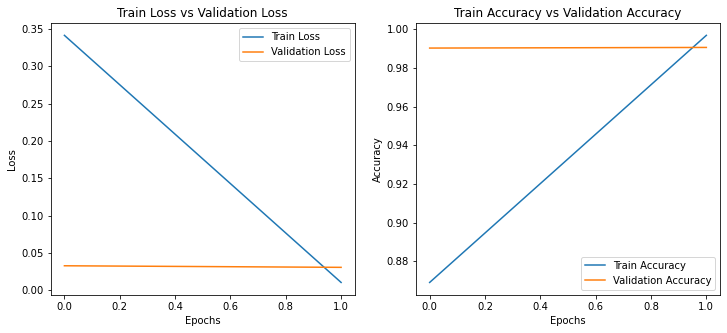

In [41]:
plot_loss_and_acc(history_cnn_word2vec)

### Using LSTM

In [54]:
# Model Checkpoint and EarlyStopping
filepath_lstm = "Updated//modelISOT_LSTM_WORD2VEC_PRETRAINED.h5" # Location to get the model
checkpoint_lstm = ModelCheckpoint(filepath_lstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_lstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_lstm = [checkpoint_lstm,es_lstm]

In [55]:
vocab_size

103015

In [67]:
embed_dim

300

In [68]:
maxi

2000

In [69]:
from keras.initializers import Constant
lstm_model=Sequential()
lstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix_2),trainable=True))
lstm_model.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(64,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         30904500  
                                                                 
 lstm (LSTM)                 (None, 2000, 128)         219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [70]:
clear_session()

In [71]:
history_lstm_word2vec=lstm_model.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_lstm) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.1699 - accuracy: 0.9412WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b5c14629d90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

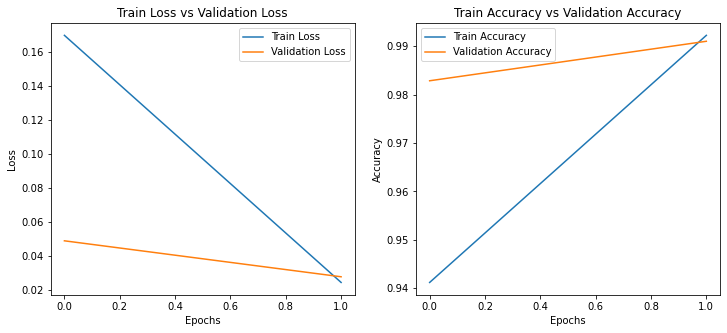

In [72]:
plot_loss_and_acc(history_lstm_word2vec)

### Using BiLSTM

In [75]:
# Model Checkpoint and EarlyStopping
filepath_bilstm = "Updated//modelISOT_BiLSTM_WORD2VEC_PRETRAINED.h5" # Location to get the model
checkpoint_bilstm = ModelCheckpoint(filepath_bilstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm = [checkpoint_bilstm,es_bilstm]

In [76]:
from keras.initializers import Constant
bilstm_model=Sequential()
bilstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix_2),trainable=True))
bilstm_model.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model.add(GlobalMaxPooling1D())
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Dense(64,activation='relu'))
bilstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
bilstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         30904500  
                                                                 
 bidirectional (Bidirectiona  (None, 2000, 256)        439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 6

In [77]:
clear_session()
history_bilstm_word2vec=bilstm_model.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_bilstm) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.1330 - accuracy: 0.9461WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b62a3e33620> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

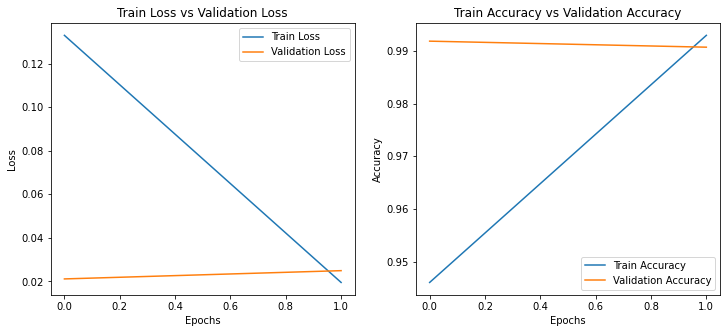

In [78]:
plot_loss_and_acc(history_bilstm_word2vec)

## Glove

##### using PreTrained

##### Download the pretrained zip file

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

##### Unzip it

In [ ]:
# !unzip glove*.zip

In [19]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [20]:
glove_path = 'Embeddings//glove.6B.300d.txt'

In [21]:
import os
glove_embeddings_index = {}
f = open(os.path.join(glove_path), encoding="utf8")

In [22]:
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()

In [23]:
print('Total %s word vectors in Glove.' % len(glove_embeddings_index))


Total 400000 word vectors in Glove.


In [24]:
embedding_gmatrix = np.random.random((len(tokenzr.word_index) + 1, embed_dim))
for word, i in tokenzr.word_index.items():
    embedding_gvector = glove_embeddings_index.get(word)
    if embedding_gvector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_gmatrix[i] = embedding_gvector

### 1D CNN

In [25]:
# Model Checkpoint and EarlyStopping
filepath = "Updated//model_ISOT_CNN_GLOVE.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

In [29]:
maxi

2000

In [26]:
warnings.filterwarnings('ignore')
cnn_model_g=Sequential()
cnn_model_g.add(Embedding(vocab_size,embed_dim,input_length=maxi))
cnn_model_g.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
cnn_model_g.add(MaxPooling1D())
cnn_model_g.add(Flatten())
cnn_model_g.add(Dense(128, activation='relu'))
cnn_model_g.add(Dense(1, activation='sigmoid'))
# compile the model
cnn_model_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(cnn_model_g.summary())

2022-06-21 10:46:05.054795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-21 10:46:05.055251: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-21 10:46:05.055788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         30804600  
                                                                 
 conv1d (Conv1D)             (None, 1998, 128)         115328    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 999, 128)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127872)            0         
                                                                 
 dense (Dense)               (None, 128)               16367744  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

In [30]:
history_cnn_glove=cnn_model_g.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9320WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b47fff510d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

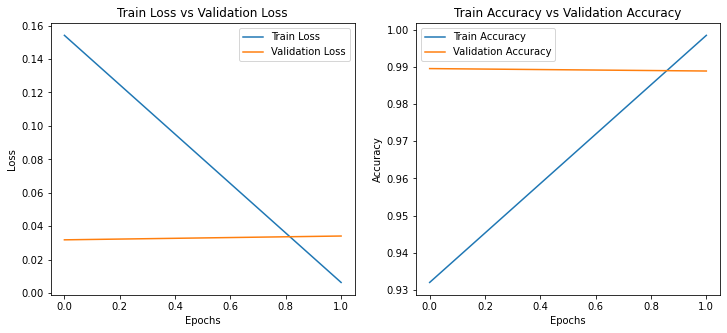

In [33]:
plot_loss_and_acc(history_cnn_glove)

### Using LSTM

In [43]:
# Model Checkpoint and EarlyStopping
filepath_lstm_g = "Updated//model_ISOT_LSTM_GLOVE.h5" # Location to get the model
checkpoint_lstm_g = ModelCheckpoint(filepath_lstm_g, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_lstm_g = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_lstm_g = [checkpoint_lstm_g,es_lstm_g]

In [44]:
vocab_size

102682

In [45]:
embed_dim

300

In [46]:
maxi

2000

In [47]:
from keras.initializers import Constant
lstm_model_g=Sequential()
lstm_model_g.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedding_gmatrix),trainable=True))
lstm_model_g.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model_g.add(GlobalMaxPooling1D())
lstm_model_g.add(Dropout(0.3))
lstm_model_g.add(Dense(64,activation='relu'))
lstm_model_g.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model_g.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
lstm_model_g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         30804600  
                                                                 
 lstm (LSTM)                 (None, 2000, 128)         219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                        

In [48]:
clear_session()

In [49]:
history_lstm_glove=lstm_model_g.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_lstm_g) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.1680 - accuracy: 0.9301WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b47ffefcd90> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

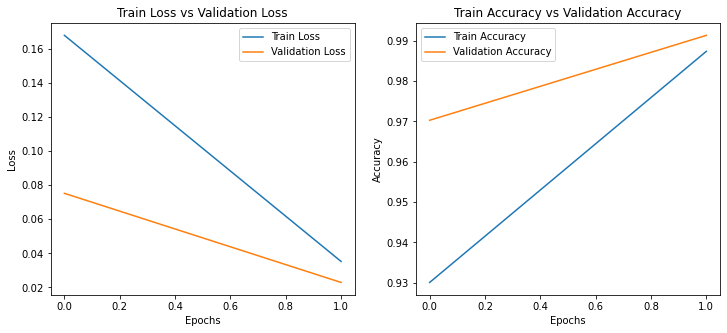

In [50]:
plot_loss_and_acc(history_lstm_glove)

### Using BiLSTM

In [57]:
# Model Checkpoint and EarlyStopping
filepath_bilstm_g = "Updated//model_ISOT_BILSTM_GLOVE.h5" # Location to get the model
checkpoint_bilstm_g = ModelCheckpoint(filepath_bilstm_g, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm_g = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm_g = [checkpoint_bilstm_g,es_bilstm_g]

In [58]:
vocab_size

102682

In [59]:
embed_dim

300

In [60]:
maxi

2000

In [61]:
from keras.initializers import Constant
bilstm_model_g=Sequential()
bilstm_model_g.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedding_gmatrix),trainable=True))
bilstm_model_g.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model_g.add(GlobalMaxPooling1D())
bilstm_model_g.add(Dropout(0.3))
bilstm_model_g.add(Dense(64,activation='relu'))
bilstm_model_g.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
bilstm_model_g.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
bilstm_model_g.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2000, 300)         30804600  
                                                                 
 bidirectional_1 (Bidirectio  (None, 2000, 256)        439296    
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                

In [62]:
clear_session()

In [63]:
history_bilstm_glove=bilstm_model_g.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_bilstm_g) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.1682 - accuracy: 0.9228WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2b4b6a1b8bf8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

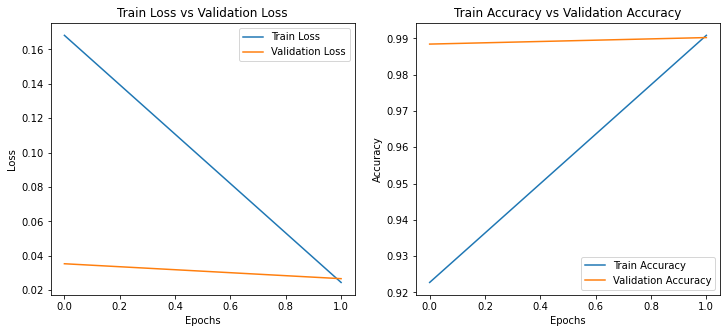

In [64]:
plot_loss_and_acc(history_bilstm_glove)